In [18]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns


torch.cuda.set_device(0) 


def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018"

In [32]:
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
# get diseases that exist in more than 0.5 percent of the samples
y=y[y.columns[y.sum()>(0.005*y.shape[0])]]
y.sum()
y.reset_index(drop=True)

,bundle branch block,ventricular premature beats,left axis deviation,right axis deviation,right bundle branch block,t wave inversion,right ventricular hypertrophy,prolonged qt interval,left ventricular hypertrophy,atrial fibrillation,...,anterior ischemia,sinus rhythm,sinus tachycardia,sinus arrhythmia,early repolarization,nonspecific st t abnormality,left anterior fascicular block,nonspecific intraventricular conduction disorder,incomplete right bundle branch block,left atrial enlargement
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10339,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10340,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
10341,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
10342,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False


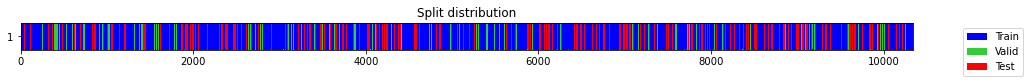

((#7242) [9518,8696,133,6385,6257,4593,5987,5257,2934,1795...],
 (#1034) [2589,6501,5016,7774,9064,7250,3419,6809,9585,3553...],
 (#2068) [7483,2140,9876,4230,2856,4039,2524,6383,8230,2158...])

In [39]:
splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.2, stratify=False, random_state=23, shuffle=True)
splits

In [40]:
# df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
# y = snomedConvert(y)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'sinus rhythm': 1752, 'left ventricular hypertrophy': 1232, 't wave abnormal': 2306, 'lateral ischaemia': 903, 'sinus bradycardia': 1677, 'right bundle branch block': 542, 'atrial fibrillation': 570, 't wave inversion': 812, 'nonspecific st t abnormality': 1883, 'atrial flutter': 186, 'av block': 74, 'ventricular premature beats': 357, 'left axis deviation': 940, 'sinus tachycardia': 1261, 'incomplete right bundle branch block': 407, 'prolonged qt interval': 1391, 'anterior ischemia': 281, 'low qrs voltages': 374, 'premature atrial contraction': 639, 'left anterior fascicular block': 180, 'right ventricular hypertrophy': 86, 'ventricular hypertrophy': 71, 'left atrial enlargement': 870, 'left bundle branch block': 231, 'bundle branch block': 116, '1st degree av block': 769, 'qwave abnormal': 464, 'right axis deviation': 83, 'sinus arrhythmia': 455, 'inferior ischaemia': 451, 'st elevation': 134, 'early repolarization': 140, 'nonspecific intraventricular conduction dis

In [6]:
from transformation_funcs import *
def save_callback(study, trial):
    if study.best_trial == trial:
        PATH = Path('./models/inception_best.pkl')
        PATH.parent.mkdir(parents=True, exist_ok=True)
        global learn
        learn.export(PATH)
def objective(trial:optuna.Trial):    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     
    tfms = []
    random_shift = trial.suggest_float("random_shift", 0.0, 1, step=.1)
    noise = trial.suggest_float("noise", 0.0, 10, step=.5) 
    norm_type = trial.suggest_categorical('norm_type', ["standardize", "normalize"])
    CutOut = trial.suggest_categorical('cut_out', [True, False])
#     depth = trial.suggest_int('depth', 7,14,step=1) # search through all integer values between 3 and 9 with 3 increment steps
    scale = trial.suggest_float("scale", 0.3, 1, step=.1) 
    
    batch_tfms = [
        TSStandardize(by_sample=True),
        tfs.RandomShift(random_shift),
        tfs.MulNoise(noise),
        tfs.Scale(scale_factor=scale)
     ]
    
    if norm_type == "Normalize":
        batch_tmfs[0] = tfs.Normalize()
    if CutOut:
        batch_tfms.append(tfs.CutOut())
    
    tfms = [None,TSMultiLabelClassification()]

    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics = [precision_multi, recall_multi, specificity_multi, F1_multi] 

    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=10,)
    global learn
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial,monitor="F1_multi"))
    learn.fit_one_cycle(100, lr_max=0.001)
    # get best f1 every scored
    f1 = np.max(np.array(learn.recorder.values)[:,-1])
    if f1>0.8:
        PATH = Path('./models/inception_best_%s.pkl'%f1)
        PATH.parent.mkdir(parents=True, exist_ok=True)
        learn.export(PATH)
    # Return the objective value
    return f1 # return the f1 value and try to maximize it

study_name = "inception_study2" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
                            pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(n_warmup_steps=50),patience=25),
                           sampler=optuna.samplers.RandomSampler())

study.optimize(objective, n_trials=100,callbacks=[save_callback])

In [ ]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True),
              tfs.RandomShift(30),
              tfs.MulNoise(3),
              tfs.CutOut(),
              tfs.Scale(scale_factor=0.5)
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
# model = MiniRocketPlus(dls.vars, dls.c,2500)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=10,)
learn = Learner(dls, model, metrics=metrics, cbs=ShowGraph(),opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=1e-4))
learn.fit_one_cycle(1000, lr_max=0.0018562679873326028)
learn.recorder.plot_metrics()

In [51]:
# PATH = Path('./models/inception_ga.pkl')
# PATH.parent.mkdir(parents=True, exist_ok=True)
# learn.export(PATH)

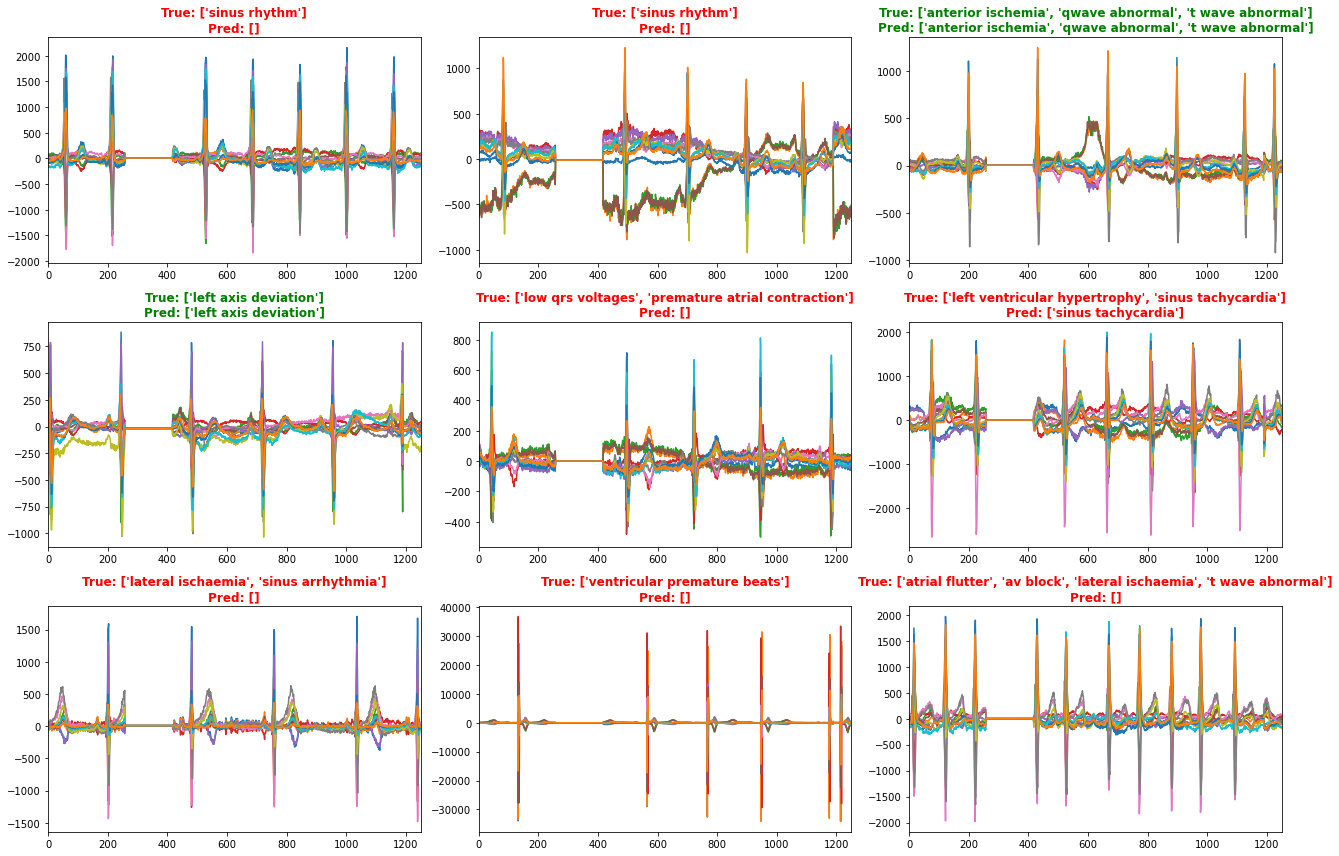

In [52]:
learn.show_results()

In [50]:
# tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True),
#               tfs.RandomShift(30),
              tfs.MulNoise(3),
#               tfs.CutOut(),
              tfs.Scale(scale_factor=0.5)
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(splits[0],splits[2])) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

y_pred = (valid_preds>0)
y_test = valid_targets

print(classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys()))

                                                  precision    recall  f1-score   support

                             1st degree av block       0.85      0.53      0.65       154
                               anterior ischemia       0.81      0.21      0.34        61
                             atrial fibrillation       0.59      0.40      0.48       113
                                  atrial flutter       0.73      0.19      0.30        42
                              atrial hypertrophy       0.00      0.00      0.00         7
                           atrial pacing pattern       0.00      0.00      0.00         8
                                        av block       0.75      0.23      0.35        13
                             bundle branch block       0.53      0.42      0.47        19
                            early repolarization       1.00      0.03      0.05        38
             incomplete left bundle branch block       0.00      0.00      0.00        16
         

In [47]:
valid_targets

TensorMultiCategory([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])